# IF240 - Apprentissage et deep learning

## Assignment 1: Kmeans, Naive Bayes, SVM 

By Aurélie Bugeau


### Objectives 
The objective is to apply classification algorithms for digit recognition

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 

# Récupère les digits avec une méthode préexistante : images, les classes correspondantes
digits = load_digits()

# 1797 images de taille 8*8 pixels
print(digits.data.shape)

fig, ax = plt.subplots(8, 5, figsize=(8, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
i=0
for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("label=%d"%digits.target[i] )
    axi.imshow(digits.images[i], interpolation='nearest', cmap=plt.cm.binary)
    i+=1

(1797, 64)


### Question 1 - Kmeans
Apply kmeans to cluster this dataset. Visualize the resulting centroids as images after reshaping them. 
Check to which cluster is assigned each data as in a classification problem. Analyse the results.

Be careful: the index of the clusters you find do not mandatorily correspond to the digit value (initial label). One way to find which label corresponds to each cluster is to visualise the centroid images, or to compute the mode of each class in the groundtruth
`
import numpy as np
from scipy.stats import mode
labels = np.zeros_like(Y)
for i in range(10):
    indices = np.where(y_pred == i)[0]
    labels[indices] = mode(digits.target[indices])[0]
    `

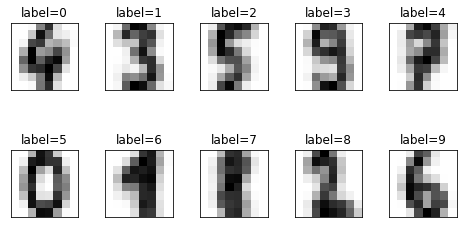

In [2]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn import metrics
import numpy as np
from seaborn import heatmap

# Globals 

# Données (tableau de 1797 images de dimension 8*8)
X=digits.data
Y=digits.target

# Nombre de classes que l'on souhaite avoir : 10 digits
n_clusters = 10
image_shape = digits.images.shape[1:]

# Applique KMeans sur nos données
clustering = KMeans(n_clusters, random_state = 0).fit(X)

# Récupères les résultats : les centroids et les labels correspondants
centroids = clustering.cluster_centers_
labels = clustering.labels_

# Créé un tableau avec pour chaque classes, les images correspondantes (tableau de taille 10,8,8)
images_centroids = np.zeros((n_clusters,image_shape[0],image_shape[1]))

# Redimenssioner les données afin d'obtenir des images 8*8
for i in range(n_clusters):
    images_centroids[i] = np.reshape(centroids[i], image_shape)

# Attribute les vrais labels aux données par rapport aux données initiales
true_labels = np.zeros_like(Y)
for i in range(10):
    indices = np.where(labels == i)[0]
    true_labels[indices] = mode(Y[indices])[0]

# Plot the centroids returned by KMeans

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
i=0
for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("label=%d"%i)
    axi.imshow(images_centroids[i], interpolation='nearest', cmap=plt.cm.binary)
    i+=1

Il est nécessaire d'attribuer les bons labels aux données. En effet, après avoir appliqué KMeans, chacuns de nos centroids a une image moyenne correspondante. **Cependant**, les labels que nous obtenons ne correspondent pas forcément au *vrai* digit, dépend de l'ordre de traitement et il s'agit d'une donnée arbitraire. Le plus important est de faire la moyenne de la classe de chaqu'une des données afin d'obtenir la classe correspondante.

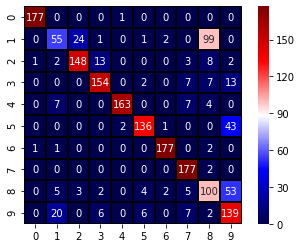

1165177.713706214


In [8]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix = metrics.confusion_matrix(Y, true_labels, labels=range(n_clusters))
ax = heatmap(confution_matrix, annot=True, cmap="seismic", square=True, linecolor="black", fmt='d', linewidths = 1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

print(clustering.inertia_)

Comme nous pouvons le voir, les résultats entre les données attendues et les données calculées sont plutôt bons. Exceptions faites concernants la classe 1 (chiffre 3) est beaucoup confondu avec les classes :
* 8 : chiffre 2
* 2 : chiffre 5
Mais aussi la classe 5 (chiffre 0) avec la classe 9 (chiffre 6). Enfin la classe 8 (chiffre 2) avec la classe 9 (chiffre 6).

On peut voir que les résultats de cette classe ne conviennent pas vraiment. En effet, on confond beaucoup plus de valeurs avec des classes différentes que l'on trouve de vrais positifs.


On peut en conclure que cette méthode peut s'apparenter à une bonne méthode au départ : on connait déjà le nombre de classes initiale mais aussi car les clusters ont une taille modulable et on exploite bien cet avantage avec nos vecteurs de taille 8\*8. Cependant, comme nous montre la matrice de confusion il y a quelques classes qui sont confondues.

De plus, KMeans est un outil non supervisé ayant pour but de rassembler les données selon des centroids (points dans l'espace) proches des données en N clusters différents. Cependant, ici notre problème est que nous avons déjà les vrais labels pour les images et donc il vaudrait mieux utiliser un algorithme supervisé dans lequel nous exploitons les vrais labels.

### Question 2
Apply Naive Bayes classification to the digit classification problem. Analyse your results.


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_bayes=digits.data
Y_bayes=digits.target

X_train, X_test, y_train, y_test = train_test_split(X_bayes, Y_bayes, test_size=0.5, random_state=0)

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)

#print("Number of mislabeled points out of a total %d points : %d".(X_test.shape[0], (y_test != y_pred).sum()))

SyntaxError: invalid syntax (<ipython-input-14-c773817dba47>, line 13)

### Question 3
Apply SVM classification to the digit classification problem. Analyse your results.


Le but de cette classification est de séparer les données selon des hypers plans afin d'avoir des groupes de données selon les 10 classes existantes. En effet, il s'agit ici d'un algorithme supervisé ce qui signifie que nous connaissons déjà les résultats concernant un ensemble de données et le but ici est d'apprendre ces dernières afin de les essayer sur un jeu de données test.

Ici, on utilisera les 1757 premières données afin de s'entraîner (données qui à chaque exécution seront aléatoires compte tenu de la permutation des indices initiale) et on testera ensuite sur les 20 dernières données de notre dataset.

Nous allons essayer de visualiser les différentes classification SVM afin de voir laquelle est potentiellement la meilleure : linéaire, not linaire

In [19]:
X_svm = digits.data
Y_svm = digits.target

# Permutation aléatoire des indices des coordonnées des points de moons
indices = np.random.permutation(len(X_svm))

# on garde des données aléatoires pour s'entrainer
X_train = X_svm[indices[:-40]]
Y_train = Y_svm[indices[:-40]]

# on en garde pour valider
X_valid = X_svm[indices[-40:-20]]
Y_valid = Y_svm[indices[-40:-20]]

# et les dernières pour tester
X_test  = X_svm[indices[-20:]]
Y_test  = Y_svm[indices[-20:]]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1757, 64)
(20, 64)
(20, 64)


(1757, 64)


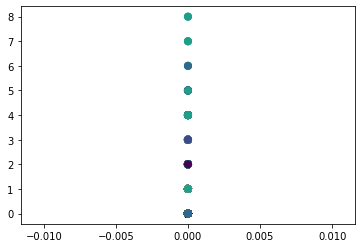

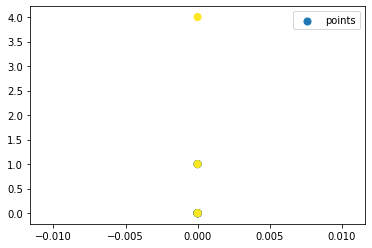

0.0970873786407767


In [25]:
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1.0)

# on applique SVM linéaire
svc.fit(X_train,Y_train)

# on va verifier l'accuracy sur les données de validation : si la précision est trop basse on repare en phase
# d'entrainement sur les données de train AFIN D'EVITER d'OVERFIT

# on affiche le SVM linéaire pour les données d'entrainement : d'apres les données en entrées on essaye
# de prédire si les

print(X_train.shape)


plt.scatter(X_train[:, 0], X_train[:, 1], c=svc.predict(X_train), s=50, cmap='viridis', label='points')
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], c=svc.predict(X_test), s=50, cmap='viridis', label='points')
plt.legend()
plt.show()

print(svc.score(X_test, Y_valid, svc.predict(X_test)))